In [32]:
!pip install --upgrade dagshub mlflow seaborn matplotlib scikit-learn numpy pandas

In [3]:
import dagshub
dagshub.init(repo_owner='nmach22', repo_name='house-prices-ml', mlflow=True)

Accessing as nmach22

Initialized MLflow to track repo "nmach22/house-prices-ml"

Repository nmach22/house-prices-ml initialized!

In [2]:
data_path =  './data/house-prices-advanced-regression-techniques'

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/house-prices-advanced-regression-techniques/test.csv
./data/house-prices-advanced-regression-techniques/data_description.txt
./data/house-prices-advanced-regression-techniques/train.csv
./data/house-prices-advanced-regression-techniques/sample_submission.csv


In [5]:
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df.shape

(1460, 81)

In [6]:
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))
test_df.shape

(1459, 80)

In [133]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

random_seed = 40

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [134]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 80), (292, 80), (1168,), (292,))

In [135]:
# print column which contains nans:
columns_with_nulls = {}
for column_name, count in X_train.isna().sum(axis=0).items():
    if count > 0:
        print(f'{column_name}: {count} - {X_train[column_name].dtype}')
        columns_with_nulls[column_name] = count

LotFrontage: 212 - float64
Alley: 1104 - object
MasVnrType: 699 - object
MasVnrArea: 7 - float64
BsmtQual: 33 - object
BsmtCond: 33 - object
BsmtExposure: 34 - object
BsmtFinType1: 33 - object
BsmtFinType2: 34 - object
Electrical: 1 - object
FireplaceQu: 540 - object
GarageType: 67 - object
GarageYrBlt: 67 - float64
GarageFinish: 67 - object
GarageQual: 67 - object
GarageCond: 67 - object
PoolQC: 1162 - object
Fence: 937 - object
MiscFeature: 1123 - object


In [136]:
len(columns_with_nulls)

19

In [137]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']

In [229]:
num_cols

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [232]:
X_train['MSSubClass'].unique()

array([ 20,  50,  60,  80,  90,  45,  70, 190, 120,  75, 160,  30,  85,
       180,  40])

In [139]:
columns_to_remove = ['Id']
# columns_to_remove += [col for col, count in columns_with_nulls.items() if count > 500]

In [140]:
columns_to_change_nans = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'Fence']
X_train[columns_to_change_nans].dtypes

Alley           object
MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
FireplaceQu     object
GarageType      object
GarageFinish    object
Fence           object
dtype: object

In [141]:
columns_to_remove

['Id']

In [142]:
one_hot_columns = list(X_train[cat_cols].nunique().index)
len(one_hot_columns)

43

In [143]:
X_train[list(set(one_hot_columns) - set(columns_to_remove) - set(columns_to_change_nans))].isna().sum()

CentralAir          0
Condition2          0
LandContour         0
ExterQual           0
LotShape            0
KitchenQual         0
SaleCondition       0
RoofMatl            0
GarageCond         67
Heating             0
ExterCond           0
MSZoning            0
Exterior2nd         0
RoofStyle           0
Condition1          0
Exterior1st         0
Electrical          1
LotConfig           0
BldgType            0
HeatingQC           0
MiscFeature      1123
SaleType            0
GarageQual         67
PavedDrive          0
LandSlope           0
HouseStyle          0
Street              0
Utilities           0
Foundation          0
Neighborhood        0
Functional          0
PoolQC           1162
dtype: int64

In [144]:
len(columns_to_remove)

1

In [145]:
len(columns_to_change_nans)

11

In [146]:
len(one_hot_columns)

43

In [147]:
len(num_cols)

37

In [148]:
len(one_hot_columns) + len(num_cols)

80

## Preprocess

In [238]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import TargetEncoder


class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, unnecessary_columns, columns_to_change,  smooth, change_value='nan'):
        self.categorical_columns = categorical_columns
        self.unnecessary_columns = unnecessary_columns
        self.columns_to_change = columns_to_change
        self.smooth = smooth
        self.change_value = change_value

    def fit(self, X, y):
         # one hot encoder
        self.enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        # self.enc = TargetEncoder(target_type='continuous', smooth=self.smooth)
        self.enc.set_output(transform="pandas")
         
        self.numerical_columns = [col for col in X.columns if X[col].dtype != 'object' and col != 'Id']
        self.categorical_columns = list(set(self.categorical_columns) - set(self.unnecessary_columns))

        self.enc.fit(X[self.categorical_columns], y)
        
        return self

    def transform(self, X):
        # Drop columns unnecessary columns
        X_transformed = X.drop(columns = self.unnecessary_columns)
        
        # Change several categorical column, which has meaningful nan values
        X_transformed[self.columns_to_change] = X_transformed[self.columns_to_change].fillna(self.change_value)
        
        # Change numerical column nan values
        X_transformed = X_transformed.fillna(value={col: 0 for col in self.numerical_columns})
        
        # Change categorical nan values with mode
        X_transformed = X_transformed.fillna(value={col: X_transformed[col].mode()[0] for col in self.categorical_columns})
        
        # make encoder
        target_encoded = self.enc.transform(X_transformed[self.categorical_columns])
        X_transformed = pd.concat([X_transformed.drop(columns=self.categorical_columns), target_encoded], axis=1)

        assert not X_transformed.isna().any().any()
            
        return X_transformed

In [239]:
from sklearn.metrics import root_mean_squared_error

def loss_fn(y_true, y_prediction):
    return root_mean_squared_error(np.log(y_true), np.log(y_prediction))


In [340]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RANSACRegressor, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer

neg_rmse_scorer = make_scorer(loss_fn, greater_is_better=False)

min_samples_options = [0.9, 0.92]

# model = RandomForestRegressor(random_state=0)
# model = RANSACRegressor(random_state=random_seed)
model = LinearRegression()
scalers = [
    StandardScaler(),
    None  # Option to use no scaler
]

kfold = KFold(n_splits=5, shuffle=True, random_state=40)

rfe = RFE(estimator=model)

param_grid = {
    'scaler': scalers,
    'rfe__n_features_to_select': [25, 30],
    'rfe__step': [1, 5, 10],
    # 'model__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    # 'preprocess__smooth': ['auto', 1, 2],
    # 'model__n_estimators': [100, 150, 200],
    # 'model__max_depth': [None, 10, 20],
    # 'model__min_samples_split': [2]
    # 'model__min_samples': min_samples_options
}

y_train_scaled = np.log(y_train)

pipeline = Pipeline([
    ('preprocess', CustomPreprocessor(categorical_columns=one_hot_columns, unnecessary_columns=columns_to_remove, smooth='auto', columns_to_change=columns_to_change_nans)),
    ('scaler', StandardScaler()),
    ('rfe', rfe),
    ('model', model)
])


In [341]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    # cv=kfold,
    scoring=neg_rmse_scorer,
    verbose=2,
    return_train_score=True,
    n_jobs=-1,
)

In [342]:
# Fit
grid_search.fit(X_train.reset_index(drop=True), y_train_scaled.reset_index(drop=True))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        CustomPreprocessor(categorical_columns=['MSZoning',
                                                                                'Street',
                                                                                'Alley',
                                                                                'LotShape',
                                                                                'LandContour',
                                                                                'Utilities',
                                                                                'LotConfig',
                                                                                'LandSlope',
                                                                                'Neighborhood',
                                                                                'Condition1',
                                                                                'Condition2',
                                                                                'BldgType',
                                                                                'HouseStyle',
                                                                                'RoofStyle',
                                                                                'RoofMatl',
                                                                                'Exterior1st',
                                                                                'Exterior2nd',
                                                                                'MasVnrType',
                                                                                'ExterQual',
                                                                                'ExterCond',
                                                                                'Foundation',
                                                                                'B...
                                                           unnecessary_columns=['Id'])),
                                       ('scaler', StandardScaler()),
                                       ('rfe',
                                        RFE(estimator=LinearRegression())),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'rfe__n_features_to_select': [25, 30],
                         'rfe__step': [1, 5, 10],
                         'scaler': [StandardScaler(), None]},
             return_train_score=True,
             scoring=make_scorer(loss_fn, greater_is_better=False, response_method='predict'),
             verbose=2)

In [343]:
best_model = grid_search.best_estimator_

In [344]:
print(grid_search.best_params_)
print(-1 * grid_search.best_score_)

{'rfe__n_features_to_select': 30, 'rfe__step': 1, 'scaler': StandardScaler()}
0.012767338854638752


In [345]:
y_pred_log = best_model.predict(X_test)
y_pred = np.exp(y_pred_log)

In [346]:
y_pred

array([183828.54234212, 177765.79721776, 281661.0562061 , 170554.53411455,
       284466.90818084,  96327.7459873 , 146194.46549484,  94745.11433113,
       104216.81052758, 208186.74389964,  71735.23114416, 296261.93409389,
       187066.10752424,  98148.71396408, 140308.89902218, 262999.940851  ,
       170995.44114063, 303642.56127096, 521841.41695679, 160552.30038667,
       196855.31825167, 160249.17351967, 130900.28351539, 146229.45795675,
       209290.40993533, 121278.36621573, 263166.97351164, 189455.97634807,
       134885.89788084, 192166.11836201, 131257.25953579, 229733.19795165,
       148181.99593424, 158193.40136989, 151148.00827393, 134108.79009747,
       166786.02750936, 292494.03764779, 198373.14130511, 317659.68073783,
        92071.26802033, 115998.51227699, 132434.91825212, 172685.74902235,
        99516.31672885, 101639.10199116, 269291.73801208, 273228.11606466,
       156614.54898794, 196190.78630262, 213334.90594417, 194435.83589527,
       144776.87139058, 1

In [347]:
rmse_y_pred_test = loss_fn(y_test, y_pred)
rmse_y_pred_test

0.12000304613824493

In [348]:
y_pred_train_scaled = best_model.predict(X_train)
y_pred_train = np.exp(y_pred_train_scaled)

In [349]:
y_pred_train

array([114107.87856662, 268925.92520212, 149120.37773257, ...,
       231501.51684028, 176393.24972276, 220898.26439614], shape=(1168,))

In [350]:
rmse_y_pred_train = loss_fn(y_train, y_pred_train)
rmse_y_pred_train

0.11332358579409288

In [351]:
import matplotlib.pyplot as plt

def draw_histogram_auto_bins(data, title="Histogram", xlabel="price", ylabel="Frequency", bin_method='auto'):
    plt.hist(data, bins=bin_method)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

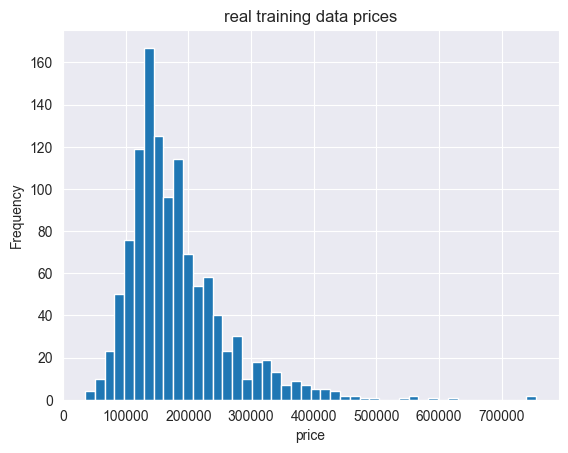

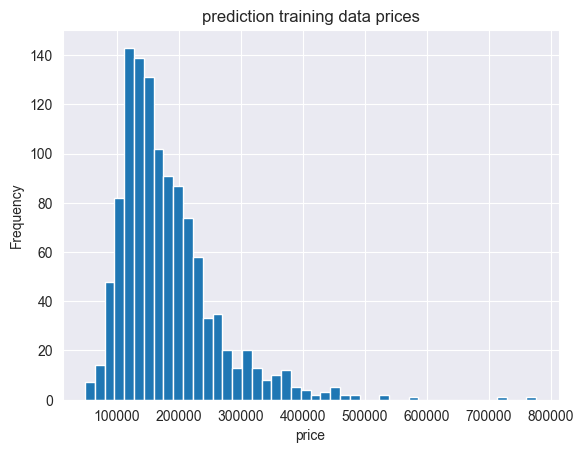

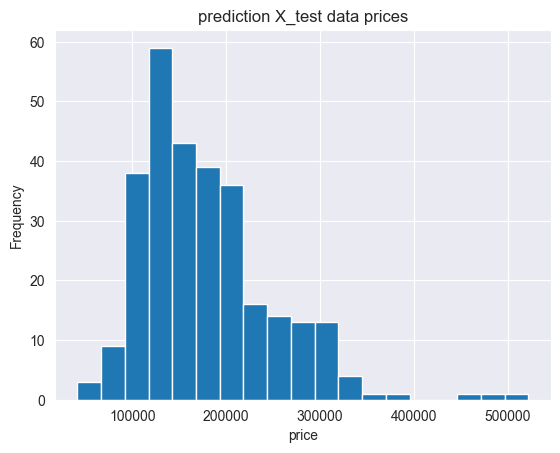

In [352]:
draw_histogram_auto_bins(y_train, title='real training data prices')
draw_histogram_auto_bins(y_pred_train, title='prediction training data prices')
draw_histogram_auto_bins(y_pred, title='prediction X_test data prices')

In [353]:
list(zip(y_test, y_pred))[:10]

[(190000, np.float64(183828.54234211962)),
 (173000, np.float64(177765.7972177555)),
 (392500, np.float64(281661.0562061029)),
 (181000, np.float64(170554.53411455138)),
 (284000, np.float64(284466.9081808381)),
 (88000, np.float64(96327.74598730006)),
 (136900, np.float64(146194.46549483808)),
 (79900, np.float64(94745.11433112879)),
 (110000, np.float64(104216.81052757926)),
 (226700, np.float64(208186.7438996377))]

In [355]:
import mlflow
from mlflow.models.signature import infer_signature

experiment_name = 'Linear Regression'
run_name = model.__class__.__name__ + '_best_linear_run'

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):
    mlflow.log_param("fillNA_numerical_value", 0)
    mlflow.log_param("fillNA_categorical_value", 0)
    mlflow.log_param("model_name", model.__class__.__name__)
    
    # Log removed columns
    columns_to_remove_str = ', '.join(columns_to_remove)
    mlflow.log_param("removed columns", columns_to_remove_str)
    
    # Log best parameters
    for param, value in grid_search.best_params_.items():
        mlflow.log_param(param, value)

    mlflow.log_metric("rmse - test", rmse_y_pred_test)
    mlflow.log_metric("rmse - train", rmse_y_pred_train)
    mlflow.log_metric("random seed", random_seed)
    
    # Log the entire pipeline
    # Create a small input example from your training set
    input_example = test_df
    
    # Get model predictions for signature
    example_predictions = best_model.predict(input_example)
    
    # Infer the signature
    signature = infer_signature(input_example, example_predictions)
    
    # Log the model with input_example and signature
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="pipeline_model",
        input_example=input_example,
        signature=signature,
    )

    print(f"Logged run_id: {mlflow.active_run().info.run_id}")

2025/04/10 02:32:35 INFO mlflow.tracking.fluent: Experiment with name 'Linear Regression' does not exist. Creating a new experiment.
/Users/nikamatcharadze/Documents/uni/ml/project/house_prices/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Logged run_id: 8b949a1397384ff3aa328e46f62516fc
🏃 View run LinearRegression_best_linear_run at: https://dagshub.com/nmach22/house-prices-ml.mlflow/#/experiments/2/runs/8b949a1397384ff3aa328e46f62516fc
🧪 View experiment at: https://dagshub.com/nmach22/house-prices-ml.mlflow/#/experiments/2
